In [85]:
# 1) Load files & detect monthly columns

In [87]:
import pandas as pd
import numpy as np
from pathlib import Path

ASSETS_P = Path("final_asset_valuation.csv")        # or conflict_resolved.csv
DS2_P    = Path("rwap25_gis_dataset2.csv")

assets = pd.read_csv(ASSETS_P)
ds2    = pd.read_csv(DS2_P)

# detect date-like columns (try dayfirst parsing used in your file e.g. '31-07-2025')
date_cols = []
for c in ds2.columns:
    try:
        # parse; dayfirst True because columns are like '31-07-2025'
        dt = pd.to_datetime(c, errors='coerce', dayfirst=True)
        if pd.notna(dt) and dt.year >= 2000:
            date_cols.append((c, dt))
    except Exception:
        pass

date_cols = sorted(date_cols, key=lambda x: x[1])
date_col_names = [c for c,dt in date_cols]
print("Detected {} monthly columns, earliest={}, latest={}".format(
    len(date_col_names),
    date_col_names[0] if date_col_names else None,
    date_col_names[-1] if date_col_names else None))

Detected 307 monthly columns, earliest=31-01-2000, latest=31-07-2025


In [89]:
# 2) Pick latest month & compute N-month rolling averages

In [91]:
# pick last month column (latest)
latest_col = date_col_names[-1]           # e.g. '31-07-2025'

# numeric conversion of time columns (coerce bad values)
ds2_ts = ds2[date_col_names].apply(pd.to_numeric, errors='coerce')

# add latest price and rolling averages (3,6,12 months)
ds2['price_latest'] = ds2_ts[latest_col]
def last_n_avg(df_ts, n):
    if n <= 0: raise ValueError
    cols = date_col_names[-n:]
    return df_ts[cols].mean(axis=1, skipna=True)

ds2['price_avg_3m']  = last_n_avg(ds2_ts, 3)
ds2['price_avg_6m']  = last_n_avg(ds2_ts, 6)
ds2['price_avg_12m'] = last_n_avg(ds2_ts, 12)

In [93]:
# 3) Compute momentum, pct_changes, volatility, trend (slope)

In [95]:
# pct changes: (latest - old) / old
def safe_pct(a, b):
    return (a - b) / b.replace({0: np.nan})

# 1m, 3m, 12m change
def pct_change_from(df_ts, months_ago):
    if months_ago <= 0: raise ValueError
    col_old = date_col_names[-months_ago]
    return safe_pct(df_ts[latest_col], df_ts[col_old])

ds2['pct_chg_1m']  = pct_change_from(ds2_ts, 1)
ds2['pct_chg_3m']  = pct_change_from(ds2_ts, 3)
ds2['pct_chg_12m'] = pct_change_from(ds2_ts, 12)

# volatility: std over windows
ds2['vol_6m']  = ds2_ts[date_col_names[-6:]].std(axis=1, ddof=0)
ds2['vol_12m'] = ds2_ts[date_col_names[-12:]].std(axis=1, ddof=0)

# trend / slope (linear regression slope on last k months) use numpy polyfit
def slope_last_k(series_k):
    # series_k: pd.Series of last k values (time order)
    vals = series_k.values
    if np.isnan(vals).all(): return np.nan
    x = np.arange(len(vals))
    # ignore NaNs: select valid points
    mask = np.isfinite(vals)
    if mask.sum() < 2: return np.nan
    coeffs = np.polyfit(x[mask], vals[mask], 1)  # slope, intercept
    return coeffs[0]

def slope_k(df_ts, k):
    cols = date_col_names[-k:]
    return df_ts[cols].apply(lambda row: slope_last_k(row), axis=1)

ds2['trend_6m']  = slope_k(ds2_ts, 6)
ds2['trend_12m'] = slope_k(ds2_ts, 12)

In [97]:
# 4) (Optional) Seasonal profile: average by month-of-year (helps if seasonal)

In [99]:
# build month-of-year profile using column datetimes
# map date_col_names to month numbers
col_months = [pd.to_datetime(c, dayfirst=True).month for c in date_col_names]
# build monthly mean for each region (12 numbers)
mo_series = []
for i, row in ds2_ts.iterrows():
    # for months 1..12 find mean of every month occurrence
    mmeans = {}
    for m in range(1,13):
        vals = [row[j] for j,mm in enumerate(col_months) if mm==m]
        vals = pd.to_numeric(vals, errors='coerce')
        if vals.size and np.isfinite(vals).any():
            mmeans[f'month_mean_{m:02d}'] = np.nanmean(vals)
        else:
            mmeans[f'month_mean_{m:02d}'] = np.nan
    mo_series.append(mmeans)
month_df = pd.DataFrame(mo_series)
ds2 = pd.concat([ds2, month_df], axis=1)

C:\Users\gupta\AppData\Local\Temp\ipykernel_13280\1933084464.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vals = [row[j] for j,mm in enumerate(col_months) if mm==m]


In [101]:
# 5) Save the derived region features (so we can reuse)

In [103]:
region_features = [
    'RegionID','RegionName','RegionType','State','City','Metro','CountyName',
    'price_latest','price_avg_3m','price_avg_6m','price_avg_12m',
    'pct_chg_1m','pct_chg_3m','pct_chg_12m','vol_6m','vol_12m','trend_6m','trend_12m'
]
region_features = [c for c in region_features if c in ds2.columns]  # keep present cols
region_feat_df = ds2[region_features].copy()
region_feat_df.to_csv("region_time_features.csv", index=False)
print("Saved region_time_features.csv")

Saved region_time_features.csv


In [105]:
# 6) Map each asset to nearest region (logical summary, code)

In [107]:
from sklearn.neighbors import BallTree
import pgeocode
import numpy as np

# prepare region coords: if ds2 has lat/lon columns use them; else derive from RegionName (zip)
lat_col = 'Latitude' if 'Latitude' in ds2.columns else None
lon_col = 'Longitude' if 'Longitude' in ds2.columns else None

if lat_col and lon_col:
    region_coords = ds2[['RegionID','RegionName', lat_col, lon_col]].dropna(subset=[lat_col,lon_col]).copy()
    region_coords = region_coords.rename(columns={lat_col:'region_lat', lon_col:'region_lon'})
else:
    nomi = pgeocode.Nominatim('us')
    region_coords = ds2[['RegionID','RegionName']].drop_duplicates().copy()
    region_coords['region_zip'] = region_coords['RegionName'].astype(str).apply(lambda z: z.zfill(5) if str(z).strip().isdigit() else z)
    # query lat/lon for each zip
    coords = []
    for z in region_coords['region_zip'].unique():
        r = nomi.query_postal_code(str(z))
        coords.append((z, r.latitude if hasattr(r,'latitude') else np.nan, r.longitude if hasattr(r,'longitude') else np.nan))
    coord_df = pd.DataFrame(coords, columns=['region_zip','region_lat','region_lon'])
    region_coords = region_coords.merge(coord_df, left_on='region_zip', right_on='region_zip', how='left')

# prepare assets coordinates: prefer explicit lat/lon in assets, else fill from asset zip via pgeocode
asset_lat_col = None
asset_lon_col = None
for candidate in ['Latitude','latitude','lat']:
    if candidate in assets.columns:
        asset_lat_col = candidate; break
for candidate in ['Longitude','longitude','lon']:
    if candidate in assets.columns:
        asset_lon_col = candidate; break

if asset_lat_col and asset_lon_col:
    assets['asset_lat'] = pd.to_numeric(assets[asset_lat_col], errors='coerce')
    assets['asset_lon'] = pd.to_numeric(assets[asset_lon_col], errors='coerce')
else:
    # fill from asset zip
    assets['zip_std'] = assets.get('zip', assets.get('Zip Code', '')).astype(str).apply(lambda s: ''.join(ch for ch in s if ch.isdigit()).zfill(5) if s else np.nan)
    nomi = pgeocode.Nominatim('us')
    # build zip->coords map for unique zips
    u = assets['zip_std'].dropna().unique()
    zcoords = {}
    for z in u:
        r = nomi.query_postal_code(str(z))
        zcoords[z] = (r.latitude if hasattr(r,'latitude') else np.nan, r.longitude if hasattr(r,'longitude') else np.nan)
    assets['asset_lat'] = assets['zip_std'].map(lambda z: zcoords.get(z,(np.nan,np.nan))[0])
    assets['asset_lon'] = assets['zip_std'].map(lambda z: zcoords.get(z,(np.nan,np.nan))[1])

# build BallTree
# convert deg -> rad
reg_coords = region_coords[['region_lat','region_lon']].dropna().values
reg_coords_rad = np.radians(reg_coords)
tree = BallTree(reg_coords_rad, metric='haversine')

# query each asset -> nearest region
asset_coords = assets[['asset_lat','asset_lon']].values
asset_coords_rad = np.radians(asset_coords)
dist_rad, ind = tree.query(asset_coords_rad, k=1)   # nearest only
dist_km = dist_rad[:,0] * 6371.0
nearest_idx = ind[:,0]
assets['nearest_region_index'] = nearest_idx
# map region info back
region_coords = region_coords.reset_index(drop=True)
assets['nearest_region_zip'] = region_coords.loc[nearest_idx, 'RegionName'].values
assets['nearest_region_lat'] = region_coords.loc[nearest_idx, 'region_lat'].values
assets['nearest_region_lon'] = region_coords.loc[nearest_idx, 'region_lon'].values
assets['nearest_dist_km'] = dist_km

In [108]:
# 7) Merge region time features into assets

In [109]:
# assume region_feat_df has RegionName or RegionID as join key
# if you used RegionName (zip) as region identifier:
assets = assets.merge(region_feat_df, left_on='nearest_region_zip', right_on='RegionName', how='left', suffixes=('','_reg'))

# now assets has: price_latest, price_avg_3m, pct_chg_12m, trend_12m, vol_12m, etc.
assets[['nearest_region_price','price_avg_3m','pct_chg_12m','trend_12m','vol_12m']] = assets[['price_latest','price_avg_3m','pct_chg_12m','trend_12m','vol_12m']]
# (rename to consistent names if needed)

In [113]:
# 10) Quick checks & save

In [115]:
# basic checks
print("Assets with nearest region merged:", assets['nearest_region_zip'].notna().sum(), "/", len(assets))
# save enriched asset table for ML
assets.to_csv("assets_enriched_timefeatures.csv", index=False)
print("Saved assets_enriched_timefeatures.csv")

Assets with nearest region merged: 8652 / 8652
Saved assets_enriched_timefeatures.csv


In [118]:
# 1) Load and inspect

In [120]:
import pandas as pd, numpy as np
from pathlib import Path

fn = Path("assets_enriched_timefeatures.csv")  # or assets_features_for_ml.csv / assets_final CSV
df = pd.read_csv(fn)
print("rows,cols:", df.shape)
df.head(2)

rows,cols: (8652, 61)


,asset_index,asset_index_original,location code,real property asset name,installation name,owned or leased,gsa region,street address,zip code,latitude,...,price_avg_3m,price_avg_6m,price_avg_12m,pct_chg_1m,pct_chg_3m,pct_chg_12m,vol_6m,vol_12m,trend_6m,trend_12m
0,0,0,ga2338,thompson bridge rd bldg,NaN,l,4,2565 thompson bridge rd,30501,34.33903,...,444407.640967,446726.70670,448913.314575,0.0,-0.008877,-0.018926,2655.927209,2925.627156,-1538.019926,-771.479039
1,1,1,wi1771,345 west washington avenue,NaN,l,5,345 w washington ave,53703,43.07140,...,444812.359267,447472.81495,443995.981383,0.0,-0.031738,-0.016513,5708.556090,5812.475018,-1642.287797,462.202394


In [122]:
# 2) Auto-select candidate features (skip age & available if absent)

In [124]:
# Candidate groups
spatial = [c for c in ['asset_lat','asset_lon','nearest_dist_km'] if c in df.columns]
region_time = [c for c in df.columns if any(sub in c for sub in ['nearest_region_price','price_avg','pct_chg','trend_','vol_'])]
# remove any unwanted like columns with '12m' if you want shorter list — keep for now
asset_specific = [c for c in ['area_log','rentable_sqft','price_per_sqft'] if c in df.columns]

# Exclude age/available as you said
asset_specific = [c for c in asset_specific if 'age' not in c.lower() and 'available' not in c.lower()]

feature_cols = spatial + region_time + asset_specific
# de-duplicate and keep order
feature_cols = list(dict.fromkeys(feature_cols))
print("Feature columns (count={}):".format(len(feature_cols)))
print(feature_cols)

Feature columns (count=15):
['asset_lat', 'asset_lon', 'nearest_dist_km', 'nearest_region_price', 'nearest_region_price_navg', 'price_avg_3m', 'price_avg_6m', 'price_avg_12m', 'pct_chg_1m', 'pct_chg_3m', 'pct_chg_12m', 'vol_6m', 'vol_12m', 'trend_6m', 'trend_12m']


In [128]:
# run this to list any columns that look like price/time/nearest info
price_like = [c for c in df.columns if any(k in c.lower() for k in ['price','latest','region','nearest'])]
print("Price-like columns in df (sample):")
for c in price_like:
    print("  ", c)

# show a few sample values for likely candidates
cands = [c for c in price_like if any(k in c.lower() for k in ['price','latest'])]
print("\nSample values (first 5 rows) for candidate price columns:")
print(df[cands].head())

Price-like columns in df (sample):
   gsa region
   regionid
   price_latest
   price_latest_date
   nearest_region_zip
   nearest_region_lat
   nearest_region_lon
   nearest_region_price
   nearest_region_price_navg
   nearest_region_metro
   nearest_region_county
   nearest_region_city
   nearest_region_state
   nearest_dist_km
   estimated_price
   nearest_region_index
   RegionID
   RegionName
   RegionType
   price_latest_reg
   price_avg_3m
   price_avg_6m
   price_avg_12m

Sample values (first 5 rows) for candidate price columns:
   price_latest price_latest_date  nearest_region_price  \
0   315321.3891        2025-07-31           315321.3891   
1   437620.9190        2025-07-31           437620.9190   
2   321951.6561        2025-07-31           321951.6561   
3   288681.2816        2025-07-31           288681.2816   
4   312586.7830        2025-07-31           312586.7830   

   nearest_region_price_navg  estimated_price  price_latest_reg  \
0              444407.640967     86

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

# load your enriched file (adjust path if different)
fn = Path("assets_enriched_timefeatures.csv")
df = pd.read_csv(fn)
print("Loaded:", fn, "shape:", df.shape)

# ---------- 1) Choose target price from available columns ----------
# priority order (you can tweak)
priority = [
    'price_latest',                # asset-level latest price (best)
    'price_latest_reg',            # maybe same as above with suffix
    'price_latest_num',
    'nearest_region_price',        # nearest region latest price
    'nearest_region_price_navg',   # normalized average
    'estimated_price',             # earlier computed estimate you may have
    'price_avg_3m',                # fallback: recent avg
    'price_avg_12m'
]

chosen_col = None
for c in priority:
    # try direct, case-insensitive and substring match
    if c in df.columns:
        if df[c].notna().sum() > 0:
            chosen_col = c
            break
    else:
        # loose search
        for col in df.columns:
            if c.replace('_',' ').lower() in col.lower() or c.lower() in col.lower():
                if df[col].notna().sum() > 0:
                    chosen_col = col
                    break
        if chosen_col is not None:
            break

if chosen_col is None:
    raise RuntimeError("No suitable price column found. Inspect df.columns and pick a price column manually.")

# make numeric and assign
df['target_price'] = pd.to_numeric(df[chosen_col], errors='coerce')
print(f"Using '{chosen_col}' as target_price. Non-null count:", df['target_price'].notna().sum(), "/", len(df))

# ---------- 2) Build feature list automatically ----------
# spatial
spatial = [c for c in ['asset_lat','asset_lon','nearest_dist_km'] if c in df.columns]

# region-time features (pick columns that look like derived time features)
region_time = [c for c in df.columns if any(k in c.lower() for k in
                                               ['nearest_region_price','price_avg','pct_chg','trend_','vol_','navg'])]
# remove the target column itself if accidentally included
region_time = [c for c in region_time if c != chosen_col and c != 'target_price']

# asset-specific (you said no age/available now, but keep area-related if present)
asset_specific = [c for c in ['rentable_sqft','area_log','price_per_sqft'] if c in df.columns]

feature_cols = spatial + region_time + asset_specific
# dedupe & ensure exist
feature_cols = [c for i,c in enumerate(feature_cols) if c in df.columns and c not in feature_cols[:i]]
print("Feature columns ({}): {}".format(len(feature_cols), feature_cols))

if len(feature_cols) == 0:
    raise RuntimeError("No features found. Check that df contains asset_lat/asset_lon or region features.")

# ---------- 3) Prepare training set ----------
mask = df['target_price'].notna()
print("Labeled rows:", mask.sum())

if mask.sum() < 20:
    print("Warning: very few labeled rows. Consider using region-level training or more labels.")

X_all = df[feature_cols].copy()
y_all = df['target_price'].copy()

# choose grouping key to avoid leakage (nearest_region_zip or RegionName)
group_col = None
for cand in ['nearest_region_zip','RegionName','region_zip','RegionID','regionid']:
    if cand in df.columns:
        group_col = cand
        break
print("Grouping by:", group_col)

# split: grouped if possible, else random
if group_col is not None and mask.sum() > 20:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = df.loc[mask, group_col]
    train_idx, test_idx = next(gss.split(X_all.loc[mask], y_all.loc[mask], groups=groups))
    X_train = X_all.loc[mask].iloc[train_idx].copy()
    X_test  = X_all.loc[mask].iloc[test_idx].copy()
    y_train = y_all.loc[mask].iloc[train_idx].copy()
    y_test  = y_all.loc[mask].iloc[test_idx].copy()
else:
    # random split
    X_train, X_test, y_train, y_test = train_test_split(X_all[mask], y_all[mask], test_size=0.2, random_state=42)

print("Train/test sizes:", X_train.shape, X_test.shape)

# ---------- 4) Baseline pipeline: median impute + RandomForest ----------
pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# ---------- 5) Evaluation ----------
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2  = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test.replace({0:np.nan}))) * 100

print(f"\nResults (on test set):\n  Target column: {chosen_col}\n  MAE: {mae:.2f}\n  RMSE: {rmse:.2f}\n  R²: {r2:.3f}\n  MAPE: {mape:.2f}%")

# ---------- 6) Feature importances ----------
rf = pipe.named_steps['model']
importances = rf.feature_importances_
fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("\nTop features:\n", fi.head(20))

# ---------- 7) Predict for all assets, save output ----------
X_all_imputed = X_all.copy().fillna(X_all.median())
df['predicted_price_model'] = pipe.predict(X_all_imputed)
df['used_for_training'] = df['target_price'].notna()

out_path = Path("assets_with_model_predictions.csv")
df.to_csv(out_path, index=False)
print("\nSaved predictions to:", out_path)

Loaded: assets_enriched_timefeatures.csv shape: (8652, 61)
Using 'price_latest' as target_price. Non-null count: 8036 / 8652
Feature columns (15): ['asset_lat', 'asset_lon', 'nearest_dist_km', 'nearest_region_price', 'nearest_region_price_navg', 'price_avg_3m', 'price_avg_6m', 'price_avg_12m', 'pct_chg_1m', 'pct_chg_3m', 'pct_chg_12m', 'vol_6m', 'vol_12m', 'trend_6m', 'trend_12m']
Labeled rows: 8036
Grouping by: nearest_region_zip
Train/test sizes: (6546, 15) (1490, 15)


C:\Users\gupta\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Results (on test set):
  Target column: price_latest
  MAE: 645.53
  RMSE: 3140.83
  R²: 1.000
  MAPE: 0.17%

Top features:
 nearest_region_price         0.998901
asset_lat                    0.000207
vol_12m                      0.000175
nearest_dist_km              0.000108
nearest_region_price_navg    0.000086
price_avg_12m                0.000079
asset_lon                    0.000077
price_avg_3m                 0.000070
price_avg_6m                 0.000061
trend_12m                    0.000056
trend_6m                     0.000054
pct_chg_3m                   0.000044
pct_chg_12m                  0.000043
vol_6m                       0.000040
pct_chg_1m                   0.000000
dtype: float64

Saved predictions to: assets_with_model_predictions.csv


In [138]:
# Load the CSV with predictions
df = pd.read_csv("assets_with_model_predictions.csv")

# Create a new column for log-transformed predicted prices
df["log_predicted_price"] = np.log1p(df["predicted_price_model"])  # log(1 + price) to handle 0 safely

# Save the updated CSV
df.to_csv("assets_with_model_predictions.csv", index=False)

print("✅ Added log_predicted_price column to assets_with_model_predictions.csv")
print(df[["predicted_price_model", "log_predicted_price"]].head())

✅ Added log_predicted_price column to assets_with_model_predictions.csv
   predicted_price_model  log_predicted_price
0          315290.378837            12.661253
1          437604.038694            12.989072
2          321914.424666            12.682044
3          288681.281600            12.573082
4          312577.206933            12.652610


## Data Analysis

In [141]:
# dataset dimensions and the first few rows.

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("assets_enriched_timefeatures.csv")

print(df.shape)
df.head()

(8652, 61)


,asset_index,asset_index_original,location code,real property asset name,installation name,owned or leased,gsa region,street address,zip code,latitude,...,price_avg_3m,price_avg_6m,price_avg_12m,pct_chg_1m,pct_chg_3m,pct_chg_12m,vol_6m,vol_12m,trend_6m,trend_12m
0,0,0,ga2338,thompson bridge rd bldg,NaN,l,4,2565 thompson bridge rd,30501,34.339030,...,444407.640967,446726.706700,448913.314575,0.0,-0.008877,-0.018926,2655.927209,2925.627156,-1538.019926,-771.479039
1,1,1,wi1771,345 west washington avenue,NaN,l,5,345 w washington ave,53703,43.071400,...,444812.359267,447472.814950,443995.981383,0.0,-0.031738,-0.016513,5708.556090,5812.475018,-1642.287797,462.202394
2,2,2,mn1743,1301 1/2 7th st. nw,NaN,l,5,1301 1/2 7th st nw,55901,44.031849,...,321293.803000,321263.129000,319130.507642,0.0,0.003871,0.023393,400.532716,2627.589745,52.946589,692.978524
3,3,3,md1008,woodlawn office complex,NaN,l,3,1718 woodlawn dr,21207,39.314760,...,288140.083833,287648.132283,284788.862633,0.0,0.003176,0.030105,617.119832,3144.271556,352.763929,879.881586
4,4,4,co1890,466 tucker sreet,NaN,l,8,466 tucker st,81625,40.513620,...,311315.450033,309497.602883,306800.668492,0.0,0.008079,0.039394,2010.053595,3390.272157,1162.503574,968.532000


In [145]:
# min, max, mean, std, etc.

In [147]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
asset_index,8652.0,4325.500000,2497.761598,0.000000,2162.750000,4325.500000,6488.250000,8.651000e+03
asset_index_original,8652.0,4325.500000,2497.761598,0.000000,2162.750000,4325.500000,6488.250000,8.651000e+03
gsa region,8652.0,6.074549,2.800394,1.000000,4.000000,6.000000,8.000000,1.100000e+01
zip code,8652.0,52735.417822,29960.493643,602.000000,24202.000000,53224.000000,79853.000000,9.992900e+04
latitude,8652.0,37.479663,6.553988,-14.329803,33.449590,38.727570,41.307142,7.129243e+01
longitude,8652.0,-92.681015,20.046432,-170.719580,-105.079500,-88.734978,-78.848296,1.457506e+02
building rentable square feet,8652.0,41773.436279,121371.230099,0.000000,3532.807500,9256.000000,25684.000000,2.287669e+06
available square feet,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
construction date,8602.0,1993.458731,22.444827,1809.000000,1999.000000,2000.000000,2000.000000,2.027000e+03
congressional district,8652.0,2924.376329,1711.674354,101.000000,1225.000000,2903.000000,4701.000000,7.898000e+03


In [149]:
# Price distribution

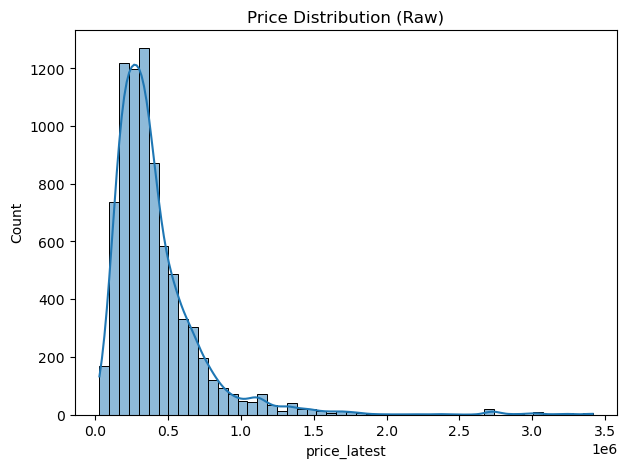

In [151]:
plt.figure(figsize=(7,5))
sns.histplot(df['price_latest'].dropna(), bins=50, kde=True)
plt.title("Price Distribution (Raw)")
plt.show()

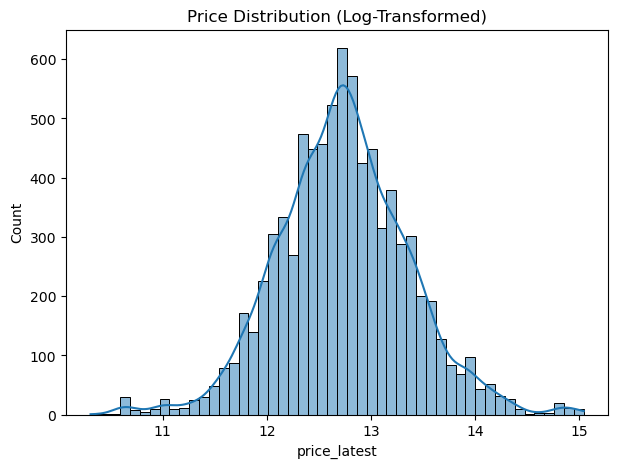

In [153]:
plt.figure(figsize=(7,5))
sns.histplot(np.log1p(df['price_latest'].dropna()), bins=50, kde=True)
plt.title("Price Distribution (Log-Transformed)")
plt.show()

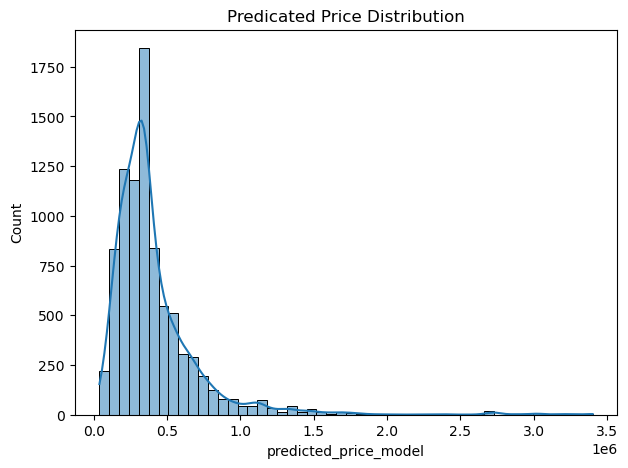

In [167]:
df1 = pd.read_csv("assets_with_model_predictions.csv")
# print(df1.columns)
plt.figure(figsize=(7,5))
sns.histplot(df1['predicted_price_model'].dropna(), bins=50, kde=True)
plt.title("Predicated Price Distribution")
plt.show()

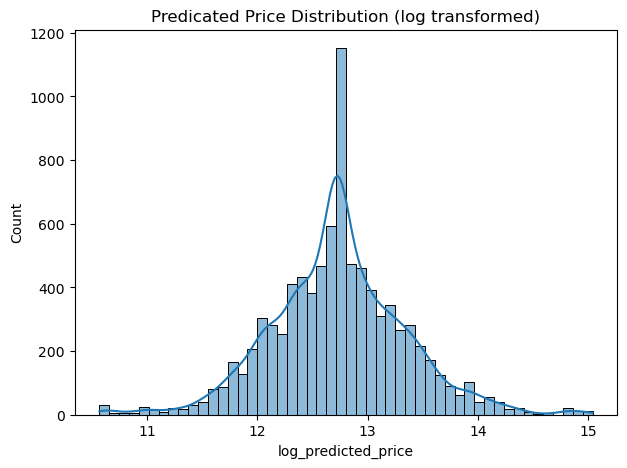

In [169]:
df1 = pd.read_csv("assets_with_model_predictions.csv")
# print(df1.columns)
plt.figure(figsize=(7,5))
sns.histplot(df1['log_predicted_price'].dropna(), bins=50, kde=True)
plt.title("Predicated Price Distribution (log transformed)")
plt.show()

In [171]:
# correlations

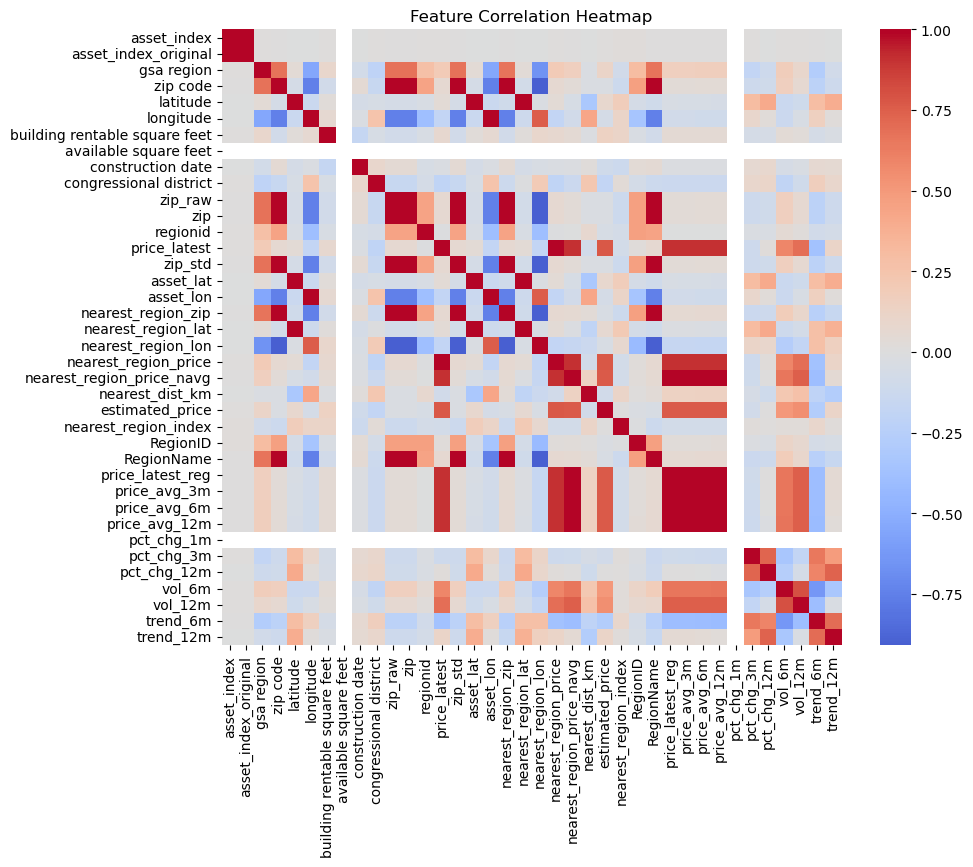

In [173]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [175]:
# Compare feature ranges

In [177]:
df[numeric_cols].agg(['min', 'max']).T.sort_values('max', ascending=False)

,min,max
price_avg_6m,34115.852068,5.949307e+06
price_avg_12m,35303.079247,5.942239e+06
nearest_region_price_navg,33406.114643,5.914734e+06
price_avg_3m,33406.114643,5.914734e+06
price_latest_reg,33281.754250,5.895952e+06
price_latest,29932.364590,3.413593e+06
nearest_region_price,29932.364590,3.413593e+06
estimated_price,103.167288,2.884460e+06
building rentable square feet,0.000000,2.287669e+06
RegionID,58221.000000,7.879720e+05
